In [5]:
import sys
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from collections import Counter
import itertools
import seaborn as sb

In [6]:
# !{sys.executable} -m pip install seaborn

# Clustering of the Candidate Sentiment Data

This part of the notebook will focus on trying to cluster danish politicians and their tweets by the sentiment of their tweets i.e. analyze whether the 8 sentiment scores output from the BertEmotion machine learning model are fundamentally different between the red and blue floor or between parties in general.

### Read and Create Sentiment Data

The data is stored in such a way that each tweet from a political candidate represents one row in the dataframe. The candidates_with_id.csv data is only loaded to get access to the party of each candidate, while the other file contains the 8 sentiment scores for each tweet that this analysis will focus on.

In [7]:
# load data
data = pd.read_csv("../data/tweets-with-logits.csv", index_col = False)
party_data = pd.read_csv("../data/candidates_with_id.csv", index_col = False)

# Add information about the party to each tweet
parties = []
for i in range(len(data)):
    try:
        parties.append(party_data.loc[data['userID'][i] == party_data['id'], 'Party'].values[0])
    except IndexError:
        parties.append('NOTFOUND')  # Some of the tweets are not available in the other dataset

data['party'] = parties
# Clean data
df = data.dropna()
df = df.drop(df[df['party'] == 'NOTFOUND'].index)

# Create new row of which block the tweet is written from
blocks = {'A': 'red', 'B': 'red', 'C': 'blue', 'D': 'blue', 'F': 'red', 'I': 'blue', 'K': 'blue', 'M': 'blue', 'O': 'blue', 'Q': 'red', 'UDEN': 'nan', 'V': 'blue', 'Å': 'red', 'Æ': 'blue', 'Ø': 'red'}
df['block'] = [blocks[part] for part in df['party']]

In [8]:
sorted(list(set(df['party'])))

['A', 'B', 'C', 'D', 'F', 'I', 'K', 'M', 'O', 'Q', 'UDEN', 'V', 'Å', 'Æ', 'Ø']

An abundance of different parties are represented. The candidates with party "UDEN" have run without a political party.

In [11]:
features = ["logits0", "logits1", "logits2", "logits3", "logits4", "logits5", "logits6", "logits7"]
clusterdf = df[features]
clusterdfviz = df[features + ['block', 'party']]
clusterdf

logits0   logits1   logits2   logits3   logits4   logits5   logits6  \
0     -0.242403  1.036899  5.875910 -0.764964 -0.644926  0.961664 -2.634241   
1      5.309263 -0.391775  0.222756  0.929578 -3.444363 -1.714997 -0.933490   
2     -1.403007 -1.446913  5.850776  0.037612  0.595455  1.513711 -2.104278   
3     -1.388914  0.613111  0.176366  0.401046 -3.125982  5.956851 -1.565234   
4      2.441553  3.980921  0.704199  0.578566 -3.741214  0.154084 -2.604905   
...         ...       ...       ...       ...       ...       ...       ...   
53337  2.605631  0.829647  5.132980 -1.297405 -3.292631 -1.374425 -1.083628   
53338 -2.017214  6.649272 -0.888306 -1.143481 -1.690741  0.744637 -0.591044   
53339  5.727797 -1.733394  2.243828 -0.457816 -1.910740 -1.862583 -0.532728   
53340  3.282433 -1.842501  0.017053  3.338105 -2.747836 -0.622682 -1.149262   
53341  6.889494  0.337715 -0.923680 -0.260158 -1.480121 -2.071679 -1.277611   

        logits7  
0     -2.345738  
1     -1.317561  
2     -2.290905  
3     -1.189016  
4     -1.194734  
...         ...  
53337 -1.560082  
53338 -1.060198  
53339 -1.680028  
53340 -0.525201  
53341 -1.281428  

[43338 rows x 8 columns]

### Preliminary Data Discovery

To analyze the potential of using a clustering algorithm for separating parties or blocks, we first look at each of the dimensions of the data as 2d scatter plots. We hope to find blobs of independent data.

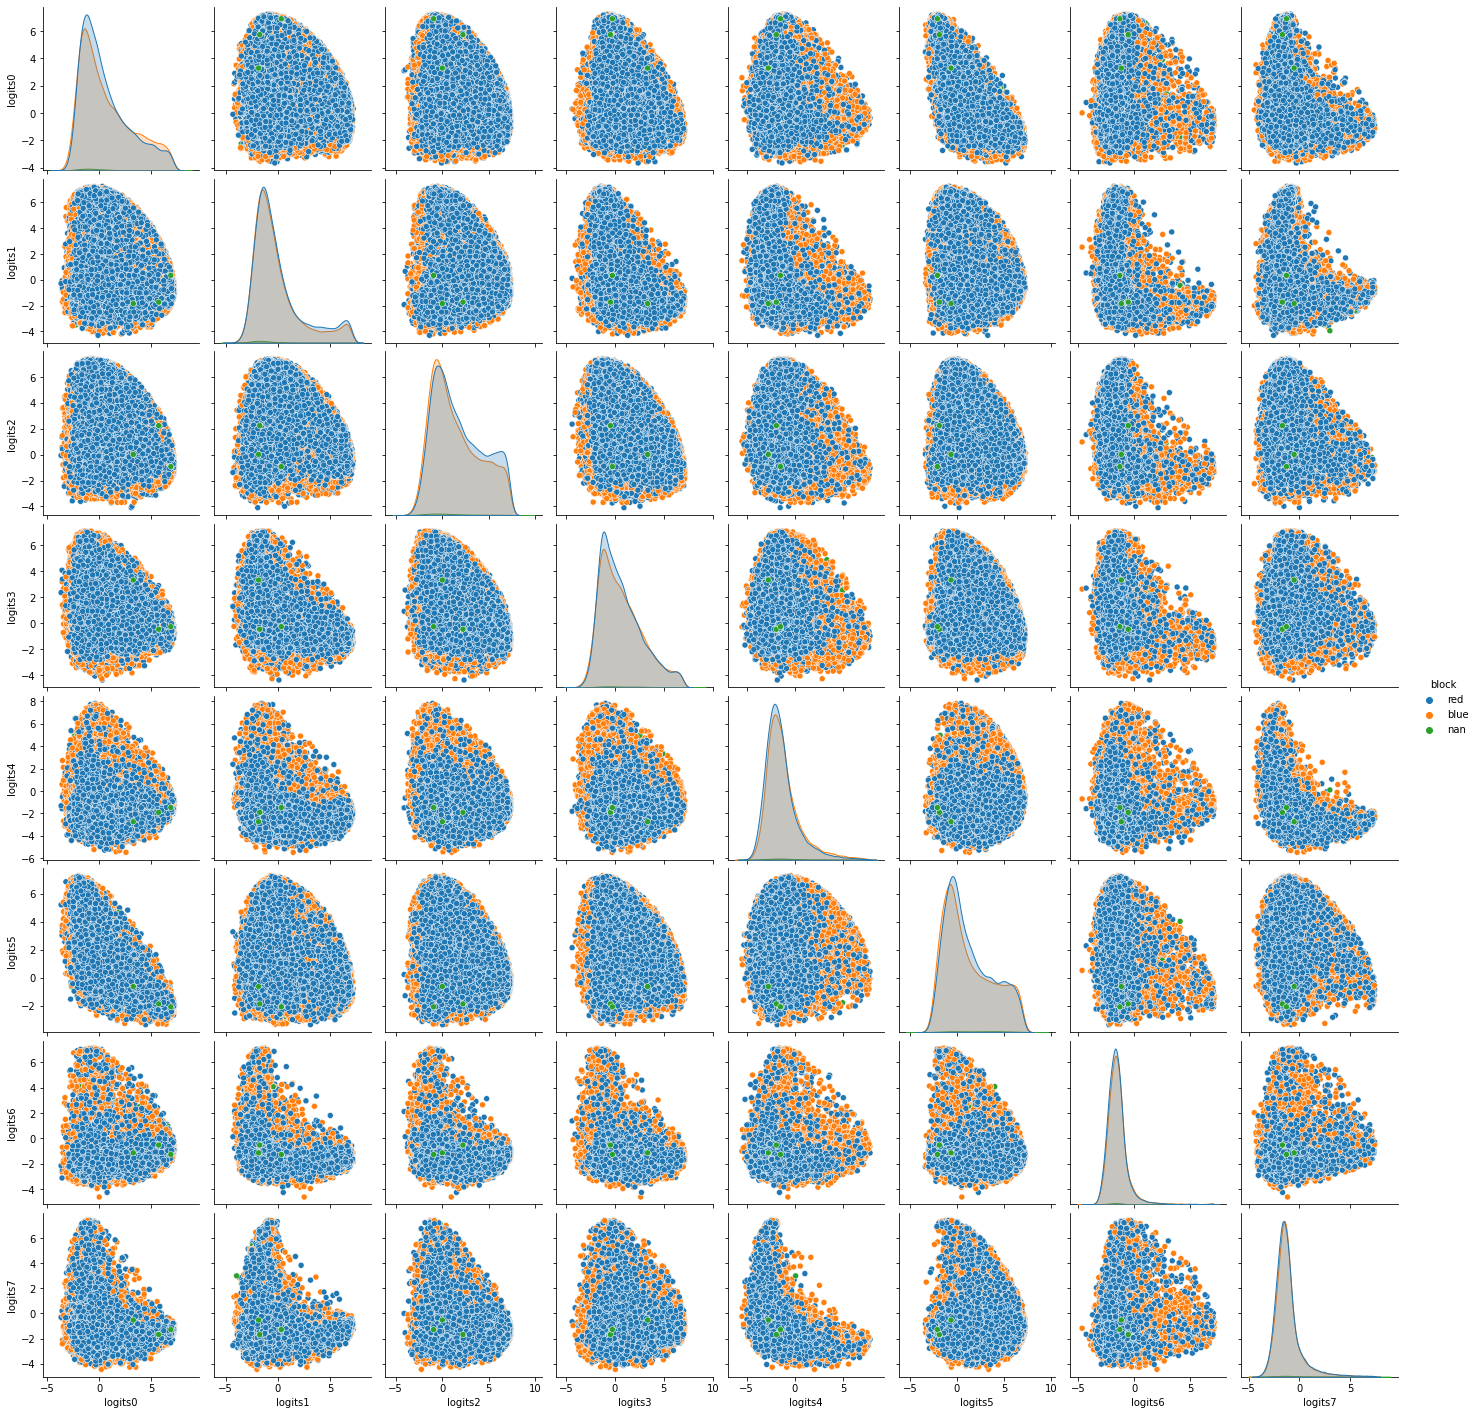

In [12]:
sb.pairplot(clusterdfviz, hue = 'block')

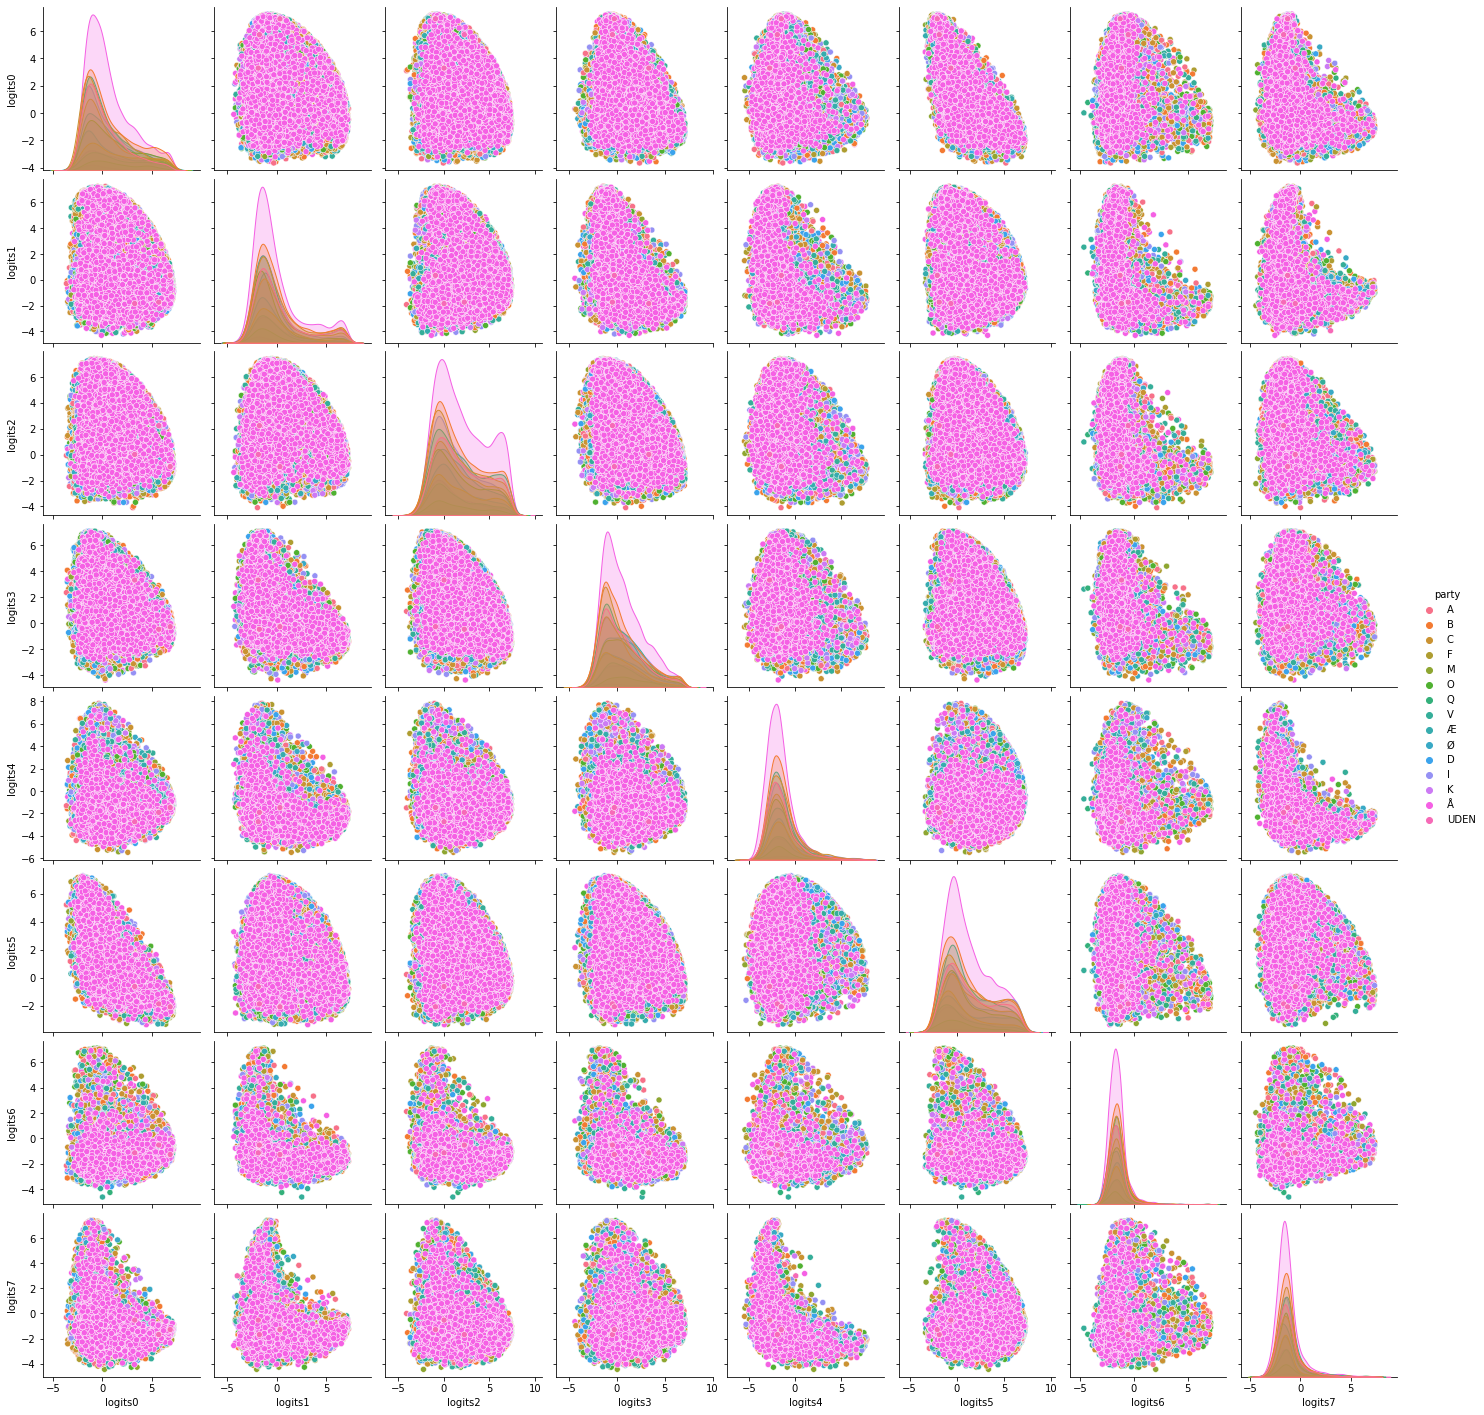

In [13]:
sb.pairplot(clusterdfviz, hue = 'party')

When considering the first visualization that is separated by block, some of the observations are separated from each other, but, as the histograms on the diagonal show, it would not be an easy task to classify the block based on only two of the dimensions. The second plot shows the exact same trend, althought the problem is worsened by having more classes. Options to get more clusterable data could be to use the entire dataset, use 3 dimensions instead of 2 or use principal component analysis (PCA). First, we try out PCA.

# Principal Component Analysis

A principal component analysis is done to allow for the data to be plotted in two dimensions and to give the best possible circumstances for clustering. Thus, only the two most meaningful principal components have been included.

### Define the data

In [36]:
# Separating out the features
x = df.loc[:, features].values

# Separating out the target
target = 'block'
y = df.loc[:,[target]].values

# Standardizing the features
# x = StandardScaler().fit_transform(x)

In [37]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [38]:
finalDf = pd.concat([principalDf, df[[target]]], axis = 1)
finalDf.head()

principal component 1  principal component 2 block
0              -0.753574              -4.243129   red
1              -4.983401               2.442238   red
2               0.766032              -2.914551   red
3               4.752651              -0.532314   red
4              -2.354723              -0.954742   red

### Show Plot of the Dimension-Reduced Data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


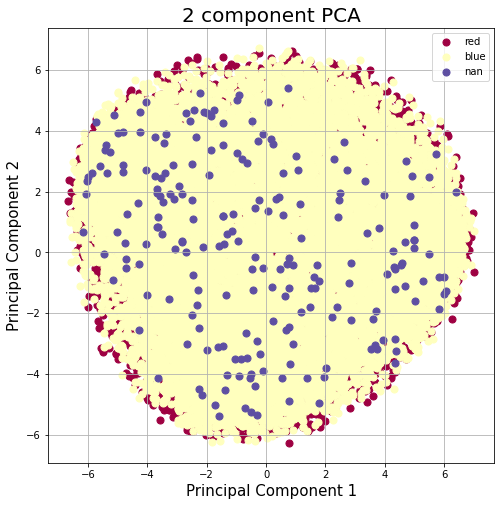

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['red', 'blue', 'nan']
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(targets))]
for targ, color in zip(targets,colors):
    indicesToKeep = finalDf[target] == targ
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Based on this plot, we once again note that it does not look possible to separate the classes from each other. Calculaing the variance explained can help to explain why this is the case.

### Variance Explained

In [40]:
var1, var2 = pca.explained_variance_ratio_
print(f"First principal component variance explained:             {var1:.3f}\nSecond principal component variance explained:            {var2:.3f}")
print(f"Total  variance explained using two principal components: {(var1 + var2):.3f}")

First principal component variance explained:             0.297
Second principal component variance explained:            0.231
Total  variance explained using two principal components: 0.528


It is clear that only about half of the variance in the data is expressed by using two different principal components. Using three principal components instead lead to about 75% of the variance being explained, but this was shown to not lead to a better clustering and also made it difficult to interpret the clustering plots.

# Clustering

### DBSCAN

In [169]:
dbscan_cluster = DBSCAN(eps=1.31, min_samples=2000).fit(clusterdf) # eps = 1.5 min_samples = 218
core_samples_mask = np.zeros_like(dbscan_cluster.labels_, dtype=bool)
core_samples_mask[dbscan_cluster.core_sample_indices_] = True
dbscan_labels = dbscan_cluster.labels_
dbscan_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [170]:
Counter(dbscan_labels).most_common()

[(0, 23437), (-1, 10193), (1, 9708)]

In [125]:
Counter(df['block']).most_common()

[('red', 22046), ('blue', 21074), ('nan', 218)]

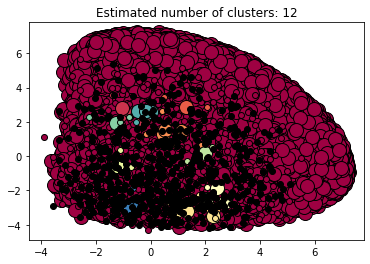

In [21]:
dbscan_unique_labels = set(dbscan_labels)
n_clusters_ = len(dbscan_unique_labels) - (1 if -1 in dbscan_labels else 0)


# Black removed and is used for noise instead.
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(dbscan_unique_labels))]
for k, col in zip(dbscan_unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = dbscan_labels == k

    xy = clusterdf[class_member_mask & core_samples_mask].to_numpy()
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = clusterdf[class_member_mask & ~core_samples_mask].to_numpy()
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### K-Means

Using K-means, it was attempted to split the data into two different clusters: One for red block and one for blue block.

In [42]:
kmeans_cluster = KMeans(n_clusters=2, random_state=0).fit(clusterdf)
kmeans_labels = kmeans_cluster.labels_
kmeans_labels

array([1, 1, 1, ..., 1, 1, 1])

In [46]:
# Calculate the accuracy - dependent on the class size, but this does not matter much, since the classes are virtually the same size
translate = {1: 'red', 0: 'blue'}
clust_acc = sum([translate[lab] for lab in kmeans_labels] == df['block']) / len(df)
block_baseline = max(list(Counter(df['block']).values())) / len(df)
print(f"Block clustering accuracy: {clust_acc:.3f}")
print(f"Block baseline accuracy:   {block_baseline:.3f}")

Block clustering accuracy: 0.505
Block baseline accuracy:   0.509


The accuracy is of the clustering is sadly about as bad as average, which was expected when the data did not look clusterable.

### Performing K-Means on only some of the dimensions

Despite the bad accuracy, it might be possible to capture some of the most separated trends in the data by using only the best dimensions. As seen in the preliminary data discovery, the two classes are best separated by logits0 and logits6. Thus, we try to use these two dimensions and one of the other dimensions to potentially get a better clustering.

In [53]:
axes = ['logits1', 'logits2', 'logits3', 'logits4', 'logits5', 'logits7']

max_acc = 0
max_acc_idx = -1
for i, ax in enumerate(axes):
    clusterdfsubset = df[['logits0', 'logits6', ax]]

    kmeans_cluster = KMeans(n_clusters=2, random_state=0).fit(clusterdfsubset)
    kmeans_labels = kmeans_cluster.labels_
    
    acc = sum([translate[lab] for lab in kmeans_labels] == df['block']) / len(df)
    if acc < 0.5:
        acc = 1 - acc

    if acc > max_acc:
        max_acc = acc
        max_acc_idx = i

print(f"The best accuracy was {max_acc:.3f} from using third dimension '{axes[max_acc_idx]}'")

The best accuracy was 0.528 from using third dimension 'logits1'


Obviously, this lead to a slight increase in accuracy, althought the method is still pretty much as good as guessing on the largest class.

### Plotting

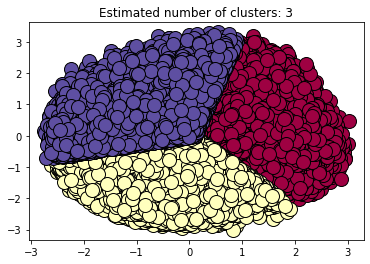

In [30]:
kmeans_unique_labels = set(kmeans_labels)
n_clusters_ = len(kmeans_unique_labels) - (1 if -1 in kmeans_labels else 0)


# Black removed and is used for noise instead.
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(kmeans_unique_labels))]
for k, col in zip(kmeans_unique_labels, colors):
    class_member_mask = kmeans_labels == k

    xy = clusterdfsubset[class_member_mask].to_numpy()
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# Conclusion

Sadly, given the results from both the K-means clustering and DBSCAN methods on a variety of different permutations of the data, it can be concluded that both methods are comparable to baseline. This does not reflect that the methods are bad but rather that the data is not fit for clustering. This is most probably due to the fact that most politicians communicate in the same manner on twitter, and therefore the data does not exhibit large permutations on average throughout different parties or blocks. Thus, we can conclude from this part of the analysis, that we are not able to effectively distinguish between parties using only their sentiment scores from a neural network.